## Latent Semantic Analysis & Sentiment Classification

### Packages and pre-defined functions

In [25]:
# basics
from pathlib import Path
import pandas as pd
import numpy as np
# tools
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import chi2
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import classification_report
# warnings
import warnings; warnings.filterwarnings('ignore')

In [5]:
# a function to display model prediction accuracy
def accuracy_summary(pipeline, X_train, y_train, X_test, y_test):
    # fit data to pipeline
    sentiment_fit = pipeline.fit(X_train, y_train)
    # predict
    y_pred = sentiment_fit.predict(X_test)
    # print accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print("accuracy score: {0:.2f}%".format(accuracy*100))
    return accuracy

### Load data file

In [6]:
# define Path
p = Path(r'C:\Users\user\Documents\Data\[Medium] Latent Semantic Analysis & Sentiment Classification\Reviews.csv')
# load data
review = pd.read_csv(p)

In [7]:
review.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [8]:
review.shape

(568454, 10)

### Data Prepare

In [9]:
review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568438 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


We see no missing values in every column

In [10]:
# include columns that are relevent to our objectives
df = review[['Score', 'Text']]

In [11]:
df.head()

,Score,Text
0,5,I have bought several of the Vitality canned d...
1,1,Product arrived labeled as Jumbo Salted Peanut...
2,4,This is a confection that has been around a fe...
3,2,If you are looking for the secret ingredient i...
4,5,Great taffy at a great price. There was a wid...


In [12]:
# Check duplicates
df.duplicated().sum() # 173448
# drop duplicates
df = df.drop_duplicates(inplace=False)

In [13]:
df.shape

(393675, 2)

### TF-IDF Analysis

In [14]:
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(df['Text'])

In [15]:
df.Text[9]

'This is a very healthy dog food. Good for their digestion. Also good for small puppies. My dog eats her required amount at every feeding.'

In [16]:
# dog
print('dog: ', end='')
print(X[9, tfidf.vocabulary_['dog']].round(4))
# puppies
print('puppies: ', end='')
print(X[9, tfidf.vocabulary_['puppies']].round(4))

dog: 0.3787
puppies: 0.3603


We see the word dog is much rarer than the word puppies in all reviews

### Create Sentiments

In [17]:
# remove neutral comments
df = df[df['Score']!= 3]
# create labels for positive and negtive attitude
df['Positive'] = np.where(df['Score'] > 3, 1, 0)
# show df
df.Positive.value_counts() / len(df)

1    0.843134
0    0.156866
Name: Positive, dtype: float64

We see 84.2% of reviews are positive, and only 15.7% are negtive

### Train Test Split

In [18]:
# define X, y
X = df.Text
y = df.Positive
# split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

In [19]:
# check the ratio of sentiments in the train set
ne = (len(X_train[y_train == 0]) / (len(X_train)*1.))*100
po = (len(X_train[y_train == 1]) / (len(X_train)*1.))*100
print(f"There are {round(po, 1)}% positives and {round(ne, 1)}% negatives in the Train data")

There are 84.3% positives and 15.7% negatives in the Train data


In [20]:
# check the ratio of sentiments in the train set
ne = (len(X_test[y_test == 0]) / (len(X_test)*1.))*100
po = (len(X_test[y_test == 1]) / (len(X_test)*1.))*100
print(f"There are {round(po, 1)}% positives and {round(ne, 1)}% negatives in the Test data")

There are 84.4% positives and 15.6% negatives in the Test data


Notice that target values are imbalanced

### Sentiment Classification 

In [21]:
# define pipeline components
cv = CountVectorizer()
rf = RandomForestClassifier(class_weight="balanced") # for imbalanced data
# define parameters
n_features = np.arange(10000, 30001, 10000)

In [22]:
# a function to find the optimal number of features
def nfeature_accuracy_checker(vectorizer=cv, n_features=n_features, stop_words=None, ngram_range=(1, 1), classifier=rf):
    result = []
    # show classifier porperties
    print(classifier)
    print("\n")
    for n in n_features:
        vectorizer.set_params(stop_words=stop_words, max_features=n, ngram_range=ngram_range)
        # create vector space and then make predictions
        checker_pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', classifier)
        ])
        print("Test result for {} features".format(n))
        nfeature_accuracy = accuracy_summary(checker_pipeline, X_train, y_train, X_test, y_test)
        result.append((n,nfeature_accuracy))
    return result

In [23]:
tfidf = TfidfVectorizer()
print("Result for trigram with stop words (Tfidf)\n")
feature_result_tgt = nfeature_accuracy_checker(vectorizer=tfidf, ngram_range=(1, 3))

Result for trigram with stop words (Tfidf)

RandomForestClassifier(class_weight='balanced')


Test result for 10000 features
accuracy score: 90.22%
Test result for 20000 features
accuracy score: 90.21%
Test result for 30000 features
accuracy score: 90.29%


In [26]:
# choose 30000 features as the optimal parameter
cv = CountVectorizer(max_features=30000,ngram_range=(1, 3))
# modeling
pipeline = Pipeline([
        ('vectorizer', cv),
        ('classifier', rf)
    ])
sentiment_fit = pipeline.fit(X_train, y_train)
y_pred = sentiment_fit.predict(X_test)
# evaluation matrix
print(classification_report(y_test, y_pred, target_names=['negative','positive']))

              precision    recall  f1-score   support

    negative       0.91      0.45      0.61     14233
    positive       0.91      0.99      0.95     76743

    accuracy                           0.91     90976
   macro avg       0.91      0.72      0.78     90976
weighted avg       0.91      0.91      0.89     90976



F1 score of 0.91 is good

### Chi-Squared for Feature Selection

We calculate Chi-square between each feature and the target and select the desired number of features with best Chi-square scores.

In [30]:
# Calculate Chi-squared score
tfidf = TfidfVectorizer(max_features=30000,ngram_range=(1, 3))
X_tfidf = tfidf.fit_transform(df.Text)
y = df.Positive
chi2score = chi2(X_tfidf, y)[0]

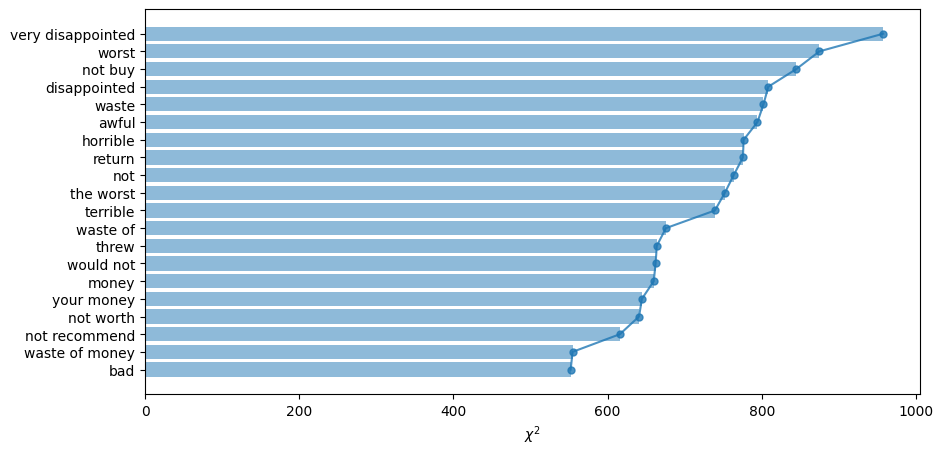

In [32]:
# plot top 20 features
plt.figure(figsize=(10,5))
scores = list(zip(tfidf.get_feature_names_out(), chi2score))
chi2 = sorted(scores, key=lambda x:x[1])
topchi2 = list(zip(*chi2[-20:]))
x = range(len(topchi2[1]))
labels = topchi2[0]
plt.barh(x,topchi2[1], align='center', alpha=0.5)
plt.plot(topchi2[1], x, '-o', markersize=5, alpha=0.8)
plt.yticks(x, labels)
plt.xlabel('$\chi^2$')
plt.show();